# Finetune semantic change detection

In [1]:
import os

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.enums import Resampling
import yaml
from einops import rearrange
import pandas as pd

from prithvi_100m.Prithvi import MaskedAutoencoderViT
from dataset import load_raster


/Users/michaelskaug/venv/prithvi-change-detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_raster(path, out_size=None):
    with rasterio.open(path) as src:
        if out_size:
            out_shape = (
                src.count,
                out_size,
                out_size
            )
        else:
            out_shape = None
            
        img = src.read(
            out_shape=out_shape,
            resampling=Resampling.bilinear
        )

    return img, src

def display_raster(raster):
    _, ax = plt.subplots(figsize=(5,5))
    ax.imshow(raster)

    return ax

<Axes: >

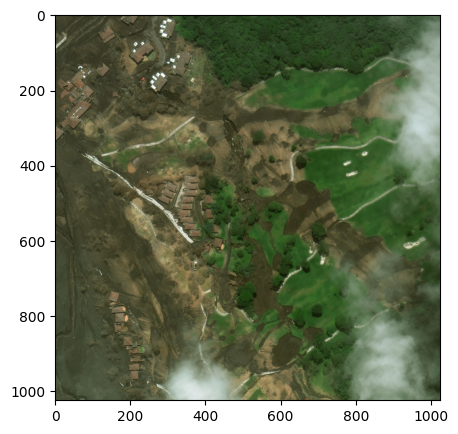

In [48]:
test_path = 'data/geotiffs/hold/images/guatemala-volcano_00000004_post_disaster.tif'

img, src = load_raster(test_path, out_size=None)
display_raster(rearrange(img, 'c h w -> h w c'))

# Load model and weights

In [25]:
# load weights
weights_path = "./prithvi_100m/Prithvi_100M.pt"
checkpoint = torch.load(weights_path, map_location="cpu")

# read model config
model_cfg_path = "./prithvi_100m/Prithvi_100M_config.yaml"
with open(model_cfg_path) as f:
    model_config = yaml.safe_load(f)

model_args, train_args = model_config["model_args"], model_config["train_params"]

# let us use only 1 frame for now (the model was trained on 3 frames)
model_args["num_frames"] = 1

# instantiate model
model = MaskedAutoencoderViT(**model_args)
model.eval()

# load weights into model
# strict=false since we are loading with only 1 frame, but the warning is expected
del checkpoint['pos_embed']
del checkpoint['decoder_pos_embed']
_ = model.load_state_dict(checkpoint, strict=False)

# Prepare Input

In [20]:
# statistics used to normalize images before passing to the model
means = np.mean(img, axis=(1, 2), keepdims=True) # 3x1x1
stds = np.std(img, axis=(1, 2), keepdims=True) # 3x1x1

def preprocess_image(image: np.array):
    # normalize image
    normalized = ((image - means) / stds)

    # add zero-filled IR channels
    normalized = np.concatenate([normalized, np.zeros((3, 224, 224))], axis=0)
    
    normalized = torch.from_numpy(normalized.reshape(1, normalized.shape[0], 1, *normalized.shape[-2:])).to(torch.float32)
    
    
    return normalized

In [21]:
normalized = preprocess_image(img)

In [26]:
features, _, _ = model.forward_encoder(normalized, mask_ratio=0)

In [29]:
print(f"Encoder features have shape {features.shape}")

# drop cls token
reshaped_features = features[:, 1:, :]

# reshape
feature_img_side_length = int(np.sqrt(reshaped_features.shape[1]))
reshaped_features = reshaped_features.view(-1, feature_img_side_length, feature_img_side_length, model_args["embed_dim"])

# channels first
reshaped_features = reshaped_features.permute(0, 3, 1, 2)
print(f"Encoder features have new shape {reshaped_features.shape}")

Encoder features have shape torch.Size([1, 197, 768])
Encoder features have new shape torch.Size([1, 768, 14, 14])


# Segmentation head

In [39]:
num_classes = 4 # No damage, minor, major, destroyed

def upscaling_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2), 
        nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=out_channels, padding=1),
        nn.ReLU()
    )

embed_dims = [model_args["embed_dim"] // (2**i) for i in range(5)]

segmentation_head = nn.Sequential(
    *[upscaling_block(embed_dims[i], embed_dims[i+1]) for i in range(4)],
    nn.Conv2d(kernel_size=1, in_channels=embed_dims[-1], out_channels=num_classes)
)


In [38]:
segmentation_head(reshaped_features).shape

torch.Size([1, 5, 224, 224])

# Debugging

In [6]:
# experimenting with reshaping to make sure different dimensions end up in the right spot

# time one = [(H x W), embedding] = [4, 3]
t1 = torch.tensor(np.zeros((4,3)))
t1[:,1] += 1
t1[:,2] += 2

# time two = [H, W, embedding] = [4, 3]
t2 = torch.tensor(np.ones((4,3)))

# flattened sequency
l = torch.concatenate([t1, t2])
l

tensor([[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

In [12]:
l.view((-1, 2, 2, 6))

tensor([[[[0., 1., 2., 0., 1., 2.],
          [0., 1., 2., 0., 1., 2.]],

         [[1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.]]]], dtype=torch.float64)

In [17]:
torch.concatenate([l[:4].view((-1, 2, 2, 3)), l[4:].view((-1, 2, 2, 3))], axis=-1)

tensor([[[[0., 1., 2., 1., 1., 1.],
          [0., 1., 2., 1., 1., 1.]],

         [[0., 1., 2., 1., 1., 1.],
          [0., 1., 2., 1., 1., 1.]]]], dtype=torch.float64)

In [2]:
metadata = pd.read_csv('data/geotiffs/hold/dataset_metadata.csv')

In [3]:
metadata.sum()

pre_date                 2017-05-21T19:19:19.000Z2013-01-05T16:02:21.00...
post_date                2017-10-11T19:19:41.000Z2016-10-01T15:29:45.00...
num_buildings                                                        54392
image_name               santa-rosa-wildfire_00000363_pre_disaster.tifh...
image_lon                                                    -83684.221971
image_lat                                                     28028.286248
disaster                 santa-rosa-wildfirehurricane-matthewhurricane-...
disaster_type            firewindfloodingfirefirewindwindwindfloodingfi...
xy_area_no-damage                                          41154284.674889
xy_area_minor-damage                                        5675732.970914
xy_area_major-damage                                        6036373.202767
xy_area_destroyed                                           3232587.969518
xy_area_un-classified                                        906807.592778
pre_gsd                  

In [4]:
damage_areas = np.array([41154284, 5675732, 6036373, 3232587])

In [5]:
total_area = len(metadata) * (1024*1024)

In [6]:
damage_areas = np.concatenate([damage_areas, [total_area - damage_areas.sum()]])
damage_areas

array([ 41154284,   5675732,   6036373,   3232587, 922222432])

In [10]:
loss_weights = 1 / (damage_areas / total_area)
loss_weights / (loss_weights.sum())

array([0.03591395, 0.26040924, 0.24485118, 0.45722297, 0.00160266])